File with final parameter estimation code.

## Package Imports

In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Justin's packages - needs bebi103 environment
# import iqplot
# import bebi103

# bokeh.io.output_notebook()

# Import seaborn for aesthetic plots 
import seaborn as sns

from tqdm.notebook import tqdm

import pandas as pd
import ast

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.themes import Theme
from bokeh.layouts import column, row
output_notebook()

from bokeh.models import ColorBar, LinearColorMapper
from bokeh.palettes import Viridis256, Cividis256, Plasma256, Magma256, Blues8, BuRd
from bokeh.models import ColumnDataSource

from bokeh.models import BasicTicker, PrintfTickFormatter


import scipy as sp
import scipy.stats as st
from scipy.optimize import minimize
# import statsmodels.tools.numdiff as smnd

# Plotting params
size = 500;

Loading BokehJS ...

## Read Data from CSV Files

In [2]:
# Specify location of csv file
directory = '../../analyzed_data/atp-hydro/';
csv_files = ['ATP.csv', 'ADP.csv', 'Phosphate.csv']
dataframes = []; 

for csv in csv_files: 
    csv_location = directory + csv;
    df = pd.read_csv(csv_location);
    dataframes.append(df); 

# Combine all dataframes into one dataframe
df_data = pd.concat(dataframes)

# Convert string-type ATP curves to array-type. 
df_data['ATP Curve (uM)'] = df_data["ATP Curve (uM)"].map(lambda curve: np.array(ast.literal_eval(curve))); 
df_data['Time Array (s)'] = df_data["Time Array (s)"].map(lambda curve: np.array(ast.literal_eval(curve))); 


In [3]:
# #### ------------- Load and Read Data ------------- ####
# ATP_conc_list = []
# ADP_conc_list = []
# P_conc_list = []
# ATP_curve_list = []
# ratio_curve_list = []
# linear_r2_list = []
# exponential_r2_list = []
# linear_hydrolysis_rate_list = []
# exponential_hydrolysis_rate_list = []
# times_list = []
# data_locations_list = []

# # for df in [df1]:
# # for df in [df1, df2, df3]:
# for df in dataframes[:1]:  # without phosphate data
#     # ATP Concentrations
#     ATP_conc_list.append(np.array(df["ATP Concentration (uM)"])); 

#     # ADP Concentrations
#     ADP_conc_list.append(np.array(df["ADP Concentration (uM)"])); 

#     # Phosphate Concentrations
#     P_conc_list.append(np.array(df["P Concentration (uM)"])); 

#     # ATP Curves
#     ATP_curve_list.append([ast.literal_eval(df["ATP Curve (uM)"][i]) for i in range(len(df))])

#     # Ratio Curves
#     ratio_curve_list.append([ast.literal_eval(df["Ratio (A.U.)"][i]) for i in range(len(df))])

#     # Goodness of Fit
#     linear_r2_list.append(np.array(df["r-squared for linear fit"])); 
#     exponential_r2_list.append(np.array(df["r-squared for exponential fit"])); 

#     # Hydrolysis Rate
#     linear_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Linear Fitting (-abs(Slope)/Motconc)"])); 
#     exponential_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Exponential Curve"])); 

#     # Time
#     times_list.append([ast.literal_eval(df["Time Array (s)"][i]) for i in range(len(df))])
    
#     # Data location
#     data_locations_list.append(df["Data Location"])

    
# times_list = [item for sublist in times_list for item in sublist];
# ATP_conc_list = [item for sublist in ATP_conc_list for item in sublist]; 
# ADP_conc_list = [item for sublist in ADP_conc_list for item in sublist];
# P_conc_list = [item for sublist in P_conc_list for item in sublist];
# ATP_curve_list = [item for sublist in ATP_curve_list for item in sublist];
# ratio_curve_list = [item for sublist in ratio_curve_list for item in sublist];
# linear_r2_list = [item for sublist in linear_r2_list for item in sublist];
# exponential_r2_list = [item for sublist in exponential_r2_list for item in sublist];
# linear_hydrolysis_rate_list = [item for sublist in linear_hydrolysis_rate_list for item in sublist];
# exponential_hydrolysis_rate_list = [item for sublist in exponential_hydrolysis_rate_list for item in sublist];
# data_locations_list = [item for sublist in data_locations_list for item in sublist]; 

In [4]:
# # Prepare data
# # remove_indices = [12, 26, 27, 46]; # manually select curves to not include
# remove_indices = []; 

# atp_array = []; 
# ytau_array = []; 
# atp0_array = []; 
# adp0_array = []; 
# p0_array = []; 
# time_array = []; 
# size_array = []; 

# j = 0; 
# for i, row in data.iterrows():
#     if i not in remove_indices: 
#         # if row["atp"][0]>500: 
#             if len(row["time"]) > 5:
#                 atp_array.append(row["atp"])
#                 ytau_array.append(row["atp"][0])
#                 atp0_array.append(row["atp0"])
#                 adp0_array.append(row["adp0"])
#                 p0_array.append(row["p0"])
#                 time_array.append(row["time"])
#                 size_array.append(len(row["atp"])); 
                
#                 j+=1; 

#                 # if j > 0: 
#                 #     break
# print(len(atp_array))

## Quality-Control Functions

In [5]:
def quality_control(df_data, min_num_of_datapoints = 5): 

    # Curve should have enough points
    quality_controlled_df = df_data[df_data["ATP Curve (uM)"].map(lambda curve: len(curve) > min_num_of_datapoints)]; 

    # Remove curves with numerical instabilities - to be revisited later.
    quality_controlled_df = quality_controlled_df[quality_controlled_df["ATP Curve (uM)"].map(lambda curve: np.all(curve < 1e4))]; 

    return quality_controlled_df; 

## Visualize Data

In [6]:
# Function to map a value to its corresponding color
def get_color(value, min_value = 0, max_value = 5000, cmap=cm.viridis):
    
    # Map value to the range [0, 1] (normalize)
    normalized_value = (value - min_value) / (max_value - min_value)

    # Get the color
    color = cmap(normalized_value)

    return color

In [7]:
df_data#['Time Array (s)'].loc[69]

,Unnamed: 0,Data Location,ATP Concentration (uM),ADP Concentration (uM),P Concentration (uM),NCD Micro Motor Concentration (uM),r-squared for exponential fit,Tau (s),A0 (uM),Ainf (uM),...,"Cal_Param [Km, Rmax, Rmin, n]",Frame Interval (s),480 Channel Exposure Time (s),405 Channel Exposure Time (s),A81D Concentration (nM),Time Array (s),ATP Curve (uM),Bound Curve,Unbound Curve,Ratio (A.U.)
0,0,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,0,0,0,1,NaN,NaN,NaN,NaN,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[5.667104596897517, 8.3388460323697, 8.3295190...","[807.9173269803757, 715.4370927579171, 713.957...","[680.7845282970292, 572.5808678463503, 571.496...","[1.1867445475022282, 1.249495281686397, 1.2492..."
1,1,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,1000,0,0,1,0.978427,5440.119656,4.936754e+02,2.156594e+01,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[364.5141775042381, 566.8489055790179, 562.094...","[1187.102834964457, 871.5993725147126, 870.901...","[384.8399986372975, 273.3118593571996, 273.230...","[3.0846659369294747, 3.1890287328351636, 3.187..."
2,2,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,100,0,0,1,-1.273953,281.107839,2.340975e+01,1.494248e+00,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[15.41510051380279, 14.938781692684056, 11.811...","[854.7907844923425, 735.4185322424313, 723.868...","[605.1621106392813, 524.6044682931588, 544.004...","[1.4124988485967147, 1.4018533517931564, 1.330..."
3,3,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,1420,0,0,1,0.903739,7050.907731,4.821327e+02,3.839475e+01,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[381.13642499300414, 631.7276451050066, 584.04...","[1169.0179047866725, 853.8649287011839, 851.23...","[377.43695588022683, 266.12453635367746, 266.4...","[3.097253426232169, 3.2085163600488307, 3.1946..."
4,4,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,200,0,0,1,0.921534,1246.332904,1.253006e+02,1.363331e-24,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[100.14061347588706, 115.62749007325766, 105.9...","[1193.4635054635908, 860.5297790529672, 856.02...","[482.0123390696243, 335.3673106695865, 340.789...","[2.4760019790514134, 2.565932193375835, 2.5118..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,67,/Volumes/Najma/Phosphate/2_phophate_variation_...,1420,0,10,1,0.877605,3286.709482,8.794832e+02,1.952667e+02,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[523.1278199415224, 1049.9134998881316, 960.06...","[1185.7203787819235, 876.1800868100399, 871.26...","[373.6698291975136, 267.47882687093806, 266.74...","[3.1731766552529934, 3.275698854596846, 3.2663..."
68,68,/Volumes/Najma/Phosphate/2_phophate_variation_...,1420,0,20,1,0.897943,4156.350435,5.932127e+02,1.869787e+02,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[438.49218454703885, 663.1992629675741, 650.55...","[1152.4585597207272, 835.6058759909977, 832.42...","[367.76752235928376, 259.7800714663094, 259.04...","[3.133660504678425, 3.2165895993271625, 3.2134..."
69,69,/Volumes/Najma/Phosphate/2_phophate_variation_...,1420,0,30,1,NaN,796.047027,5.463755e+08,1.457859e+03,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[7900, 8100, 8300, 8400, 8500, 8600, 8700, 880...","[30573.113429382844, 19930.90663931398, 21614....","[1298.2759274931468, 946.5627349567058, 945.72...","[371.65638457577654, 263.3637637188946, 263.18...","[3.4932157266046993, 3.5941266998562273, 3.5

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.027777777777777776
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.027777777777777776
0.0
0.027777777777777776
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.027777777777777776
0.0
0.0
0.0
0.0
0.027777777777777776
0.0
0.0
0.0
0.0
0.0
0.0
0.027777777777777776
0.027777777777777776
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


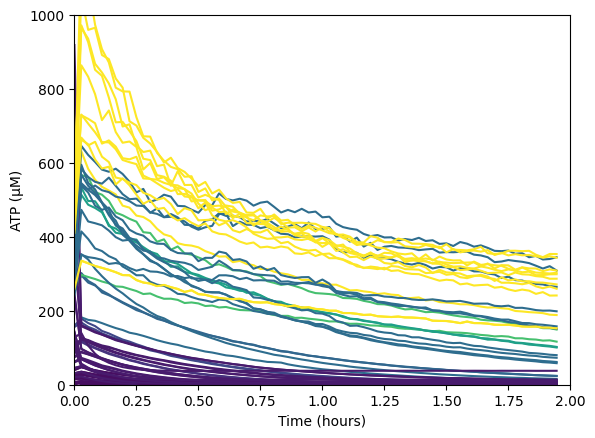

In [8]:
end_time = 2; # in hours
adp0_array = list(set(df_data["ADP Concentration (uM)"])); # Extract all adp0 values used in dataset

# Run Quality Control 
quality_control_df = quality_control(df_data); 

for index, row in quality_control_df.iterrows():
    atp0 = row['ATP Concentration (uM)'];
    adp0 = row['ADP Concentration (uM)'];                  # Read initial ADP concentration of given row.

    if adp0 == 0: # Looking at specific adp0 values.
        time = row["Time Array (s)"]/3600; # Read time array of given row.
        atp_curve = row["ATP Curve (uM)"];           # Read ATP array of given row.
        color_from_adp0 = get_color(atp0, max_value=1420);             # Obtain color of curve based on initial adp concentration
    
        if np.where(time < end_time)[0].size != 0: # Ensure array is not empty.
            end_index = np.where(time < end_time)[0][-1]; 
            print(time[0])
        else: 
            end_index = -1; # If time of data collection is less than end_time, take entire dataset. 
        
        plt.plot(time[:end_index], atp_curve[:end_index], color = color_from_adp0); 

plt.ylim([0, 1000])
plt.xlim([0, 2])

plt.xlabel("Time (hours)"); 
plt.ylabel("ATP (μM)"); 

plt.show()

In [9]:
# #### ALL ATP VS TIME PLOTS, COLOR CODED BY ADP0 VALUES

# color_mapper = LinearColorMapper(palette=Viridis256, low=min(adp0_array), high=list(set(adp0_array))[-2])

# # Function to map a value to its corresponding color
# def get_color(value, total_array):
#     second_largest_value = list(set(total_array))[-2]
#     # Map value to the range [0, 1] (normalize)
#     normalized_value = (value - min(total_array)) / (second_largest_value - min(total_array))
#     # Get the color index from the palette
#     index = int(normalized_value * (len(Viridis256) - 1))
#     # Get the color code
#     color = Viridis256[index]
#     return color

# start_index = 0; 

# # Create a ColumnDataSource
# source = ColumnDataSource(data=dict(x=time_array, y=atp_array, values=adp0_array))

# # Create figure
# p = figure(width=400, height=400, title="ATP vs Time Curves")

# df_data[["Time Array (s)", "ATP Curve (uM)", "ATP Concentration (uM)", "ADP Concentration (uM)", "P Concentration (uM)"]]

# for time_data, atp_data, atp0, adp0, p0 in zip(time_array, atp_array, atp0_array, adp0_array, p0_array): 

#     if np.where(time_data < 2*3600)[0].size != 0: 
#         end_index = np.where(time_data < 2*3600)[0][-1]; 
#     else: 
#         end_index = -1; 
    
#     if adp0 <= 1420: 
#         # atp = atp_data[start_index:end_index]; 
#         # time = np.array(time_data[start_index:end_index])/3600; 

#         atp = atp_data; 
#         time = np.array(time_data)/3600; 

#         color = get_color(adp0, adp0_array); 

#         # Add circle glyphs with color mapping
#         p.line(time, atp, color=color)

 
# # Create a color bar
# color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
#                      formatter=PrintfTickFormatter(format="%d"), 
#                      title = "Initial Concetration of ADP (μM)")

# # Add color bar to plot
# p.add_layout(color_bar, 'right')
# p.xaxis.axis_label = "Time (hours)"; 
# p.yaxis.axis_label = "ATP (μM)"; 

# # show(gridplot([[p3, p4]]))
# show(p)
# # show(p4)
